# COVID-19 in Australia: Data Analysis by Tom Midgley

## 1. Introduction

SARS-CoV-2, the novel coronavirus responsible for the ongoing COVID-19 panedemic was first identified in Wuhan in December 2019 and first detected in Australia on the 25th January 2020. Australia's first death from the virus was recorded on the 1st March 2020 and by the 11th March 2020 COVID-19 had been declared a worldwide pandemic.

Australia's geography and federal system of government meant that while Australia's experience of the pandemic was different to other countries, the experience of Australians in different states also, at times, had very different experiences too.

Using weekly reported data for newly recorded cases and deaths from the 5 mainland states, this data analysis will investigate the similarities and difference between COVID-19 infection rates and deaths across the states.

The data used  covers the first 165 weeks of the pandemic (From Jan 2020 to March 2023) with a rich data set of almost 5000 cases and death reports, each.


### 1.1 Notes, Data and Analysis Limitations


'-' used to remove empty values from columns and replaced with 0. Of note, a small number of negative values were reported, presumably a correction. This is not included in the data used in this analysis. Frequency and magnitude of negative numbers observed was small and unlikely to noticeably bias the data or impact conclusions drawn.

Of note, data sets cumulative deaths ('DEATHS') and daily reported deaths ('NET') did not always match i.e. the sum of the daily deaths did not always equal cumulative deaths. In instances observed, margin of error was small (+/-1) and therefore unlikely to noticeably bias the data or impact conclusions drawn.

Population values used are static values from 2022 and were used as population values for 2021 and 2023. Change in population from 2021 and 2022 was 2.0% or less for all states. Use of 2022 population for all years is unlikely to noticeably bias the data or impact conclusions drawn.
    

## 2. Code for User Defined Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
cwd = os.getcwd
from tabulate import tabulate


In [2]:
#function to import cases data
def file_import(x):
    file = x
    filename = file
    filename = filename.split('.')[0] #removes .tsv
    filename = filename.split('_')[1:] #splits into individual words
    state = filename[1].upper() #stores the State for later
    filename = '_'.join(filename) #creates filename
    df = pd.read_csv(file, delimiter='\t', engine='python').assign(STATE=state) #creates the dataframe, adding the state column sliced from the filename
    globals()[filename] = df

In [3]:
#function to clean cases data
def cases_cleaner(x):
    x['DATE'] = pd.to_datetime(x['DATE']) #datetime required for axes, calculations
    x['NEW']=x['NEW'].fillna(0)
    x['NEW']=x['NEW'].str.replace(',','') #remove , 1000s separator 
    x['NEW']=x['NEW'].replace(np.nan,0)
    x['NEW']=x['NEW'].replace('-',0) #removes dashes
    x['NEW']=x['NEW'].astype(int)
    x = x.drop(["CASES","VAR","NET"], axis=1) #removes useless columns
    x = x.set_index('DATE') #sets index as the date
    x = x.groupby("STATE").resample('W-FRI').sum() #converts daily data to weekly data, starting on Fridays
    x['TOTAL'] = x['NEW'].cumsum() # Adds total column and fills with a cumulative sum of new cases
    return x

In [4]:
#function to clean deaths data
def death_cleaner(x):
    # x = death_nsw
    x['DATE'] = pd.to_datetime(x['DATE']) #datetime required for axes, calculations
    x['NET']=x['NET'].fillna(0)
    x['NET']=x['NET'].str.replace(',','') #remove , 1000s separator
    x['NET']=x['NET'].replace(np.nan,0)
    x['NET']=x['NET'].replace('-',0)  #removes dashes
    x['NET']=x['NET'].astype(int)
    x = x.drop(["DEATHS","VAR"], axis=1) #removes useless columns
    x = x.set_index('DATE')
    x = x.groupby("STATE").resample('W-FRI').sum() #converts daily data to weekly data, starting on Fridays
    x['TOTAL'] = x['NET'].cumsum() # Adds total column and fills with a cumulative sum of new cases
    return x


In [5]:
#Function to calculate date of 1000th case (D0) and establish D0 delta for use as an x axis. Removes all data before 1000th case.
            
def calc_1k_case(x):
    x['1000th'] = x['TOTAL'] - 1000 #calculates cumulative summary relative to 1000th case i.e. 1000th case becomes 0, D0
    for i, row in x.iterrows(): #finds first row >0 and reports the date of that row i.e. week when 1000th case occurred
        if row['1000th'] > 0:
            date = i
            break
    date = date[1] #extract date from date time
    x['D0'] = date #fills D0 column with D0 date
    x = x.reset_index(drop=False) #couldn't do calculations with date as index, needed it back as a column
    x['D0 Delta'] = x['DATE'] - x['D0'] #Calculate delta to D0 for each week
    x['D0 Delta'] = x['D0 Delta'].dt.days.astype(int)
    x['D0 Delta'] = x['D0 Delta']/7 #convert from days to weeks
    x = x[x['D0 Delta']>= (0)]
    return x

In [6]:
#import all data
    
file_import('daily_cases_nsw.tsv')   
file_import('daily_cases_qld.tsv')    
file_import('daily_cases_sa.tsv')   
file_import('daily_cases_vic.tsv')  
file_import('daily_cases_wa.tsv')  

file_import('daily_death_nsw.tsv')   
file_import('daily_death_qld.tsv')    
file_import('daily_death_sa.tsv')   
file_import('daily_death_vic.tsv')  
file_import('daily_death_wa.tsv')  


In [7]:
#clean cases and death data

cases_nsw = cases_cleaner(cases_nsw)
cases_qld = cases_cleaner(cases_qld)
cases_sa = cases_cleaner(cases_sa)
cases_vic = cases_cleaner(cases_vic)
cases_wa = cases_cleaner(cases_wa)
death_nsw = death_cleaner(death_nsw)
death_qld = death_cleaner(death_qld)
death_sa = death_cleaner(death_sa)
death_vic = death_cleaner(death_vic)
death_wa = death_cleaner(death_wa)


In [8]:
#aggregate new deaths and cases
cases_all = pd.concat([cases_nsw, cases_qld, cases_sa, cases_vic, cases_wa])
death_all = [death_nsw, death_qld, death_sa, death_vic, death_wa]

new_cases_all = [cases_nsw['NEW'], cases_qld['NEW'], cases_sa['NEW'], cases_vic['NEW'], cases_wa['NEW']] # list of NEW cases
new_cases_all = pd.concat(new_cases_all,axis=1, keys=['NSW', 'QLD', 'SA', 'VIC', 'WA']) #concat into a DF
new_cases_all = new_cases_all.round(1) # round 


new_death_all = [death_nsw['NET'], death_qld['NET'], death_sa['NET'], death_vic['NET'], death_wa['NET']]
new_death_all = pd.concat(new_death_all,axis=1, keys=['NSW', 'QLD', 'SA', 'VIC', 'WA'])
new_death_all = new_death_all.round(1)

In [9]:
#add population columns and normalise population
#note: tried merging data frames but couldn't get the hang of it. May come back and improve this, if time.

cases_nsw['POP'] = 8153.6
cases_nsw['NEW per 1000'] = cases_nsw['NEW'] / cases_nsw['POP']
cases_qld['POP'] = 5322.1
cases_qld['NEW per 1000'] = cases_qld['NEW'] / cases_qld['POP']
cases_sa['POP'] = 1820.5
cases_sa['NEW per 1000'] = cases_sa['NEW'] / cases_sa['POP']
cases_vic['POP'] = 6613.7
cases_vic['NEW per 1000'] = cases_vic['NEW'] / cases_vic['POP']
cases_wa['POP'] = 2785.3
cases_wa['NEW per 1000'] = cases_wa['NEW'] / cases_wa['POP']

death_nsw['POP'] = 8153.6
death_nsw['NET per 1000'] = death_nsw['NET'] / death_nsw['POP']
death_qld['POP'] = 5322.1
death_qld['NET per 1000'] = death_qld['NET'] / death_qld['POP']
death_sa['POP'] = 1820.5
death_sa['NET per 1000'] = death_sa['NET'] / death_sa['POP']
death_vic['POP'] = 6613.7
death_vic['NET per 1000'] = death_vic['NET'] / death_vic['POP']
death_wa['POP'] = 2785.3
death_wa['NET per 1000'] = death_wa['NET'] / death_wa['POP']


In [10]:
#calculate date of 1000th case (D0) and establish D0 delta for use as an x axis

cases_nsw_1k = calc_1k_case(cases_nsw)
cases_qld_1k = calc_1k_case(cases_qld)
cases_sa_1k = calc_1k_case(cases_sa)
cases_vic_1k = calc_1k_case(cases_vic)
cases_wa_1k = calc_1k_case(cases_wa)

In [11]:
#Statistics to be used as variables for tabulating

nsw_total_cases = cases_nsw.iloc[164,1] #slices out the last line of the df i.e. maximum total 
qld_total_cases = cases_qld.iloc[164,1]
sa_total_cases = cases_sa.iloc[164,1]
vic_total_cases = cases_vic.iloc[164,1]
wa_total_cases = cases_wa.iloc[164,1]

nsw_total_deaths = death_nsw.iloc[164,1] #slices out the last line of the df i.e. maximum total 
qld_total_deaths = death_qld.iloc[164,1]
sa_total_deaths = death_sa.iloc[164,1]
vic_total_deaths = death_vic.iloc[164,1]
wa_total_deaths = death_wa.iloc[164,1]



In [12]:
#creation of state cases/death stats table
table = pd.DataFrame({'State': ['NSW', 'QLD', 'SA', 'VIC', 'WA'], 
                      'Total Cases': [nsw_total_cases, qld_total_cases, sa_total_cases, vic_total_cases, wa_total_cases],
                     'Total Deaths': [nsw_total_deaths, qld_total_deaths, sa_total_deaths, vic_total_deaths, wa_total_deaths]})
table = table.set_index('State')


#creation of extended cases/deaths stats table  to include population and fatality rate
table2 = pd.DataFrame({'State': ['NSW', 'QLD', 'SA', 'VIC', 'WA'], 
                      'Total Cases': [nsw_total_cases, qld_total_cases, sa_total_cases, vic_total_cases, wa_total_cases],
                     'Total Deaths': [nsw_total_deaths, qld_total_deaths, sa_total_deaths, vic_total_deaths, wa_total_deaths],
                     'Population (x1000)':[8153.6,5322.1,1820.5,6613.7,2785.3]})
table2 = table2.set_index('State')
table2['Fatality Rate (Deaths per Case)'] = round(table2['Total Deaths'] / table2['Total Cases'], 4)


#creation of extended cases/deaths stats table to include population and infection rate
table3 = pd.DataFrame({'State': ['NSW', 'QLD', 'SA', 'VIC', 'WA'], 
                      'Total Cases': [nsw_total_cases, qld_total_cases, sa_total_cases, vic_total_cases, wa_total_cases],
                     'Total Deaths': [nsw_total_deaths, qld_total_deaths, sa_total_deaths, vic_total_deaths, wa_total_deaths],
                     'Population (x1000)':[8153.6,5322.1,1820.5,6613.7,2785.3]})
table3 = table3.set_index('State')
table3['Infection Rate (Cases per 1000)'] = round(table3['Total Cases'] / table3['Population (x1000)'], 1)



## 3. Distribution of New Cases and Deaths


In [13]:
display(table)

,Total Cases,Total Deaths
State,,
NSW,3963582,6574
QLD,1812293,2835
SA,837672,1403
VIC,2971748,7424
WA,1319535,992


A number of observations from a glance at the total number of cases and deaths recorded in the states:
* NSW and Victoria recorded notably more cases and deaths than the other states, accounting together for ~60% of Australia's total reported cases and ~70% of Australia's total reported deaths
* SA reocrded the lowest number of cases but WA recorded the lowest number of deaths

Looking at the distribution of new cases:


(-10000.0, 350000.0)

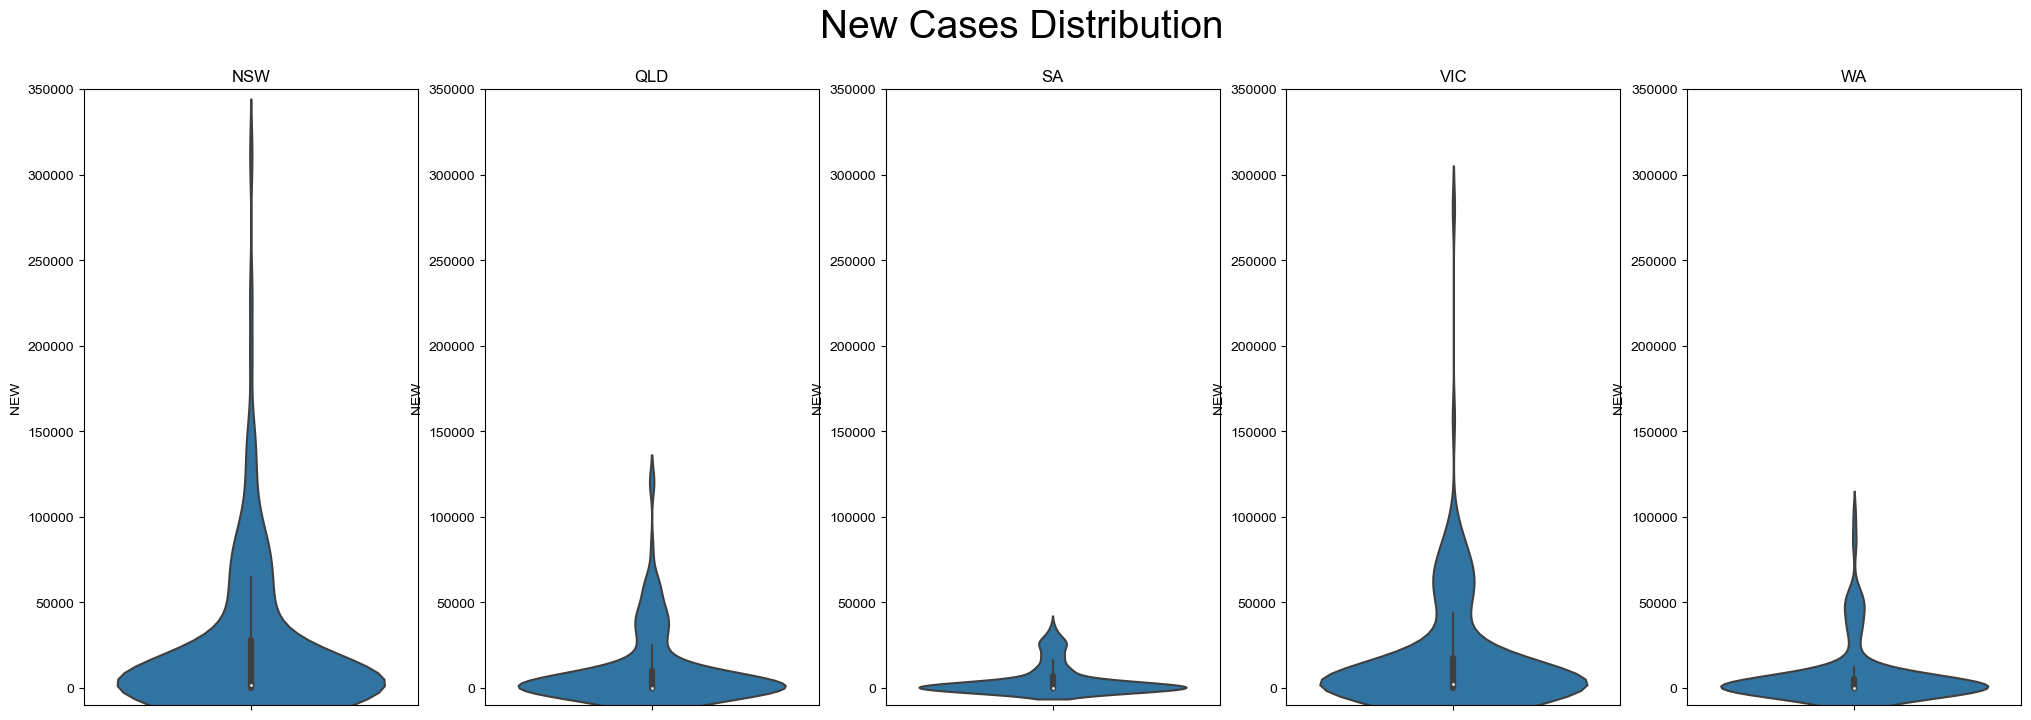

In [14]:
fig, axs = plt.subplots(ncols=5, figsize=(25, 8))
fig.suptitle('New Cases Distribution', fontsize = 28)
sns.set_context("notebook")
sns.set_style("white")

sns.violinplot(y=cases_nsw["NEW"], ax=axs[0]).set_title("NSW")
sns.violinplot(y=cases_qld["NEW"], ax=axs[1]).set_title("QLD")
sns.violinplot(y=cases_sa["NEW"], ax=axs[2]).set_title("SA")
sns.violinplot(y=cases_vic["NEW"], ax=axs[3]).set_title("VIC")
sns.violinplot(y=cases_wa["NEW"], ax=axs[4]).set_title("WA")

axs[0].set_ylim(-10000, 350000)
axs[1].set_ylim(-10000, 350000)
axs[2].set_ylim(-10000, 350000)
axs[3].set_ylim(-10000, 350000)
axs[4].set_ylim(-10000, 350000)

Text(0.5, 1.0, 'Density Curve of New Deaths')

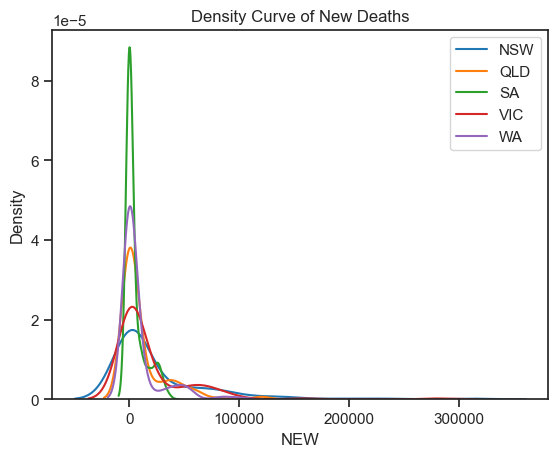

In [35]:
sns.kdeplot(x=cases_nsw['NEW'], label = "NSW")
sns.kdeplot(x=cases_qld['NEW'], label = "QLD")
sns.kdeplot(x=cases_sa['NEW'], label = "SA")
sns.kdeplot(x=cases_vic['NEW'], label = "VIC")
sns.kdeplot(x=cases_wa['NEW'], label = "WA")
plt.legend()
plt.title ("Density Curve of New Cases")


In [16]:
new_cases_all.describe().round(0)

,NSW,QLD,SA,VIC,WA
count,165.0,165.0,165.0,165.0,165.0
mean,24022.0,10984.0,5077.0,18011.0,7997.0
std,45671.0,21259.0,8860.0,34380.0,18030.0
min,0.0,0.0,0.0,0.0,0.0
25%,43.0,7.0,3.0,25.0,3.0
50%,1608.0,23.0,13.0,2573.0,14.0
75%,27869.0,10106.0,6867.0,17623.0,5055.0
max,311364.0,121013.0,35783.0,280445.0,102064.0


Data for cases does not look normally distributed (notable skew towards larger numbers) so the mean and standard deviation of this data will not provide reliable estimates so will not be discussed. Median and quartiles will be discussed instead.

Observations:
* All violin plots have similar densities/shapes
    * plots are most dense around zero and low numbers of COVID-19 cases, with an inverse relationship between size of weekly new cases and the frequency they were reported. In other words, large outbreaks were uncommon.
* NSW (1608) and VIC (2573) have the highest median new weekly cases
    * VIC's median is higher than NSW, despite NSW's higher overall reported cases number and highest weekly reported case number
    * Looking at the density of the violin plots, VIC has a larger proportion of new cases in the 50-100k range than NSW, which has a greater affect on the median than the larger 'outlier' values NSW has
* SA is notable for reporting the lowest maximum cases in one week, 37,783 cases
    * this can also be seen by the large peak in the density plot as most of SAs cases number were clustered around 0
    
Below is an alaysis of the distribution of new deaths

(0.0, 500.0)

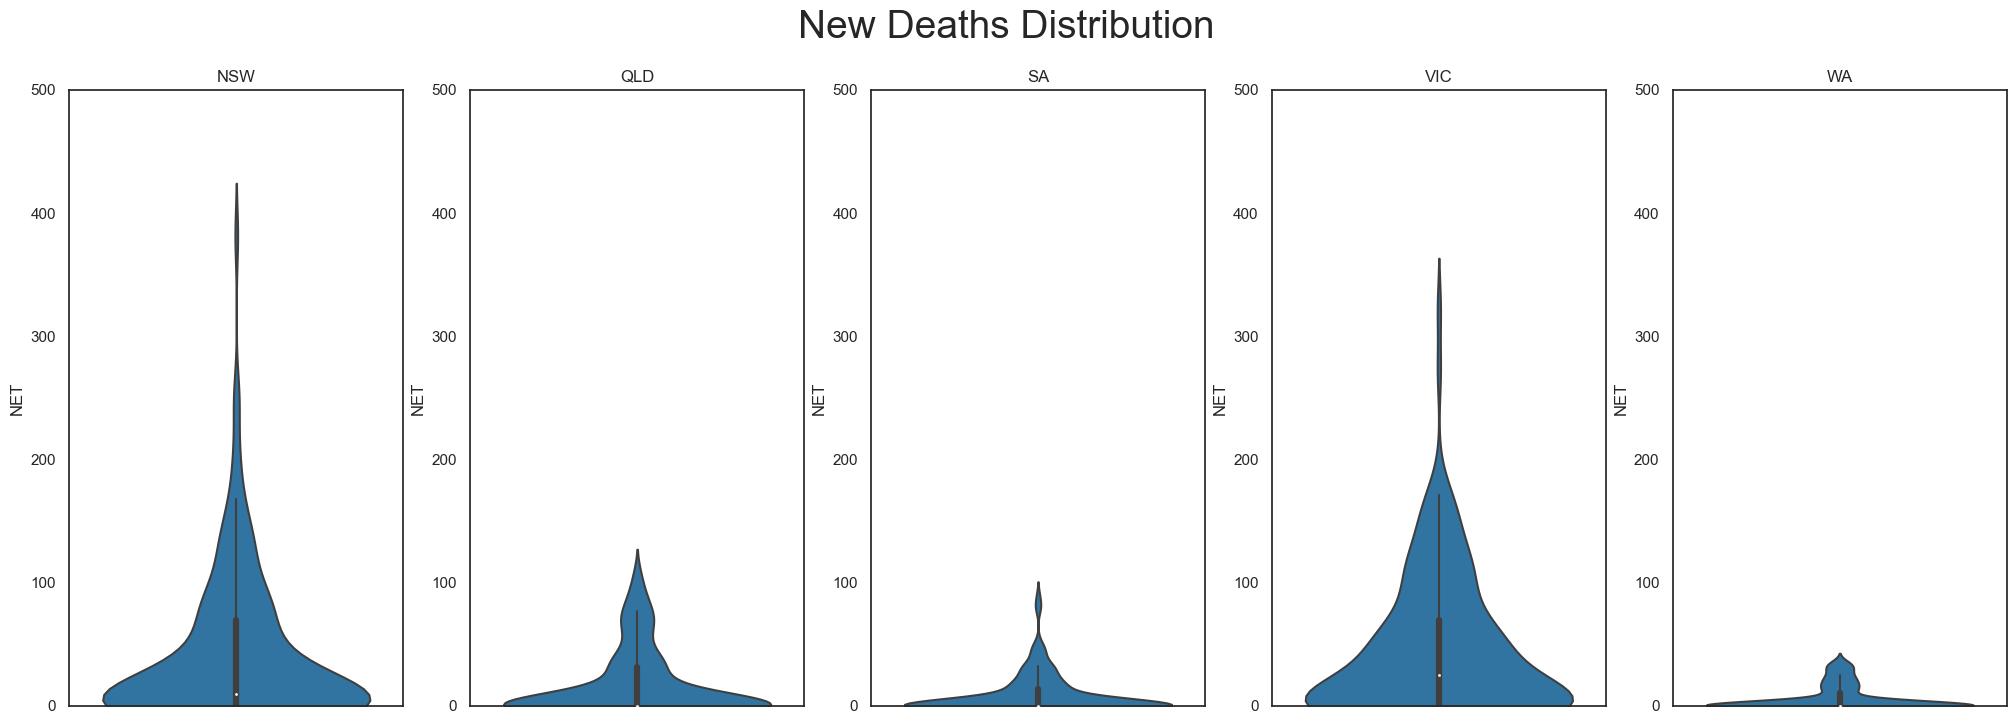

In [17]:
fig, axs = plt.subplots(ncols=5, figsize=(25, 8))
fig.suptitle('New Deaths Distribution', fontsize = 28)
sns.set_context("notebook")
sns.set_style("white")

sns.violinplot(y=death_nsw["NET"], ax=axs[0]).set_title("NSW")
sns.violinplot(y=death_qld["NET"], ax=axs[1]).set_title("QLD")
sns.violinplot(y=death_sa["NET"], ax=axs[2]).set_title("SA")
sns.violinplot(y=death_vic["NET"], ax=axs[3]).set_title("VIC")
sns.violinplot(y=death_wa["NET"], ax=axs[4]).set_title("WA")

axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
axs[2].set_ylim(0, 500)
axs[3].set_ylim(0, 500)
axs[4].set_ylim(0, 500)

Text(0.5, 1.0, 'Density Curve of New Deaths')

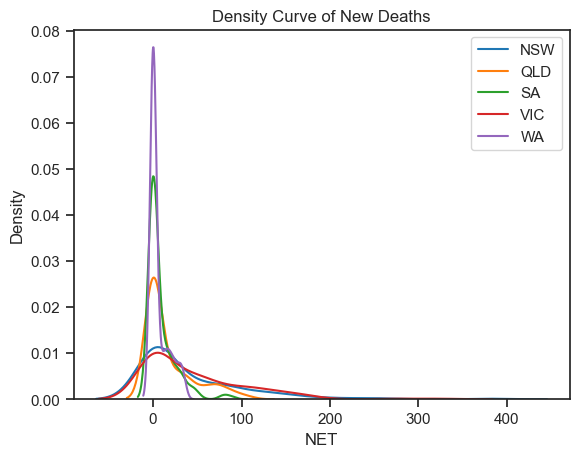

In [34]:
sns.kdeplot(x=death_nsw['NET'], label = "NSW")
sns.kdeplot(x=death_qld['NET'], label = "QLD")
sns.kdeplot(x=death_sa['NET'], label = "SA")
sns.kdeplot(x=death_vic['NET'], label = "VIC")
sns.kdeplot(x=death_wa['NET'], label = "WA")
plt.legend()
plt.title ("Density Curve of New Deaths")


In [19]:
new_death_all.describe().round(0)

,NSW,QLD,SA,VIC,WA
count,165.0,165.0,165.0,165.0,165.0
mean,40.0,17.0,9.0,45.0,6.0
std,60.0,28.0,16.0,57.0,10.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,9.0,0.0,0.0,25.0,0.0
75%,69.0,31.0,13.0,69.0,10.0
max,381.0,107.0,89.0,322.0,35.0


Data for new deaths does not look normally distributed so will only be discussed in terms of median/quartiles.

Observations:
* As with the distribution of new cases, VIC has a higher median average while NSW presents more 'extreme' data with a higher maximum
* Compared to the others, SA and WA have similar total deaths (1403 and 992, respectively), however the distribution is slightly different with SA experiencing higher Q3 and Q4 deaths
    * This is again reflected in the density plot where WA has the highest peak, close to 0

## 4. History of COVID-19 in Different States

As discussed above, the timing of initial infections was different across the states. The data is presented here normalised with respect to time by counting from the time since the 1000th infection to allow a better comparison of the COVID-19 'timecourse' between the states 


Text(0.5, 1.0, 'Cumulative COVID-19 cases by State')

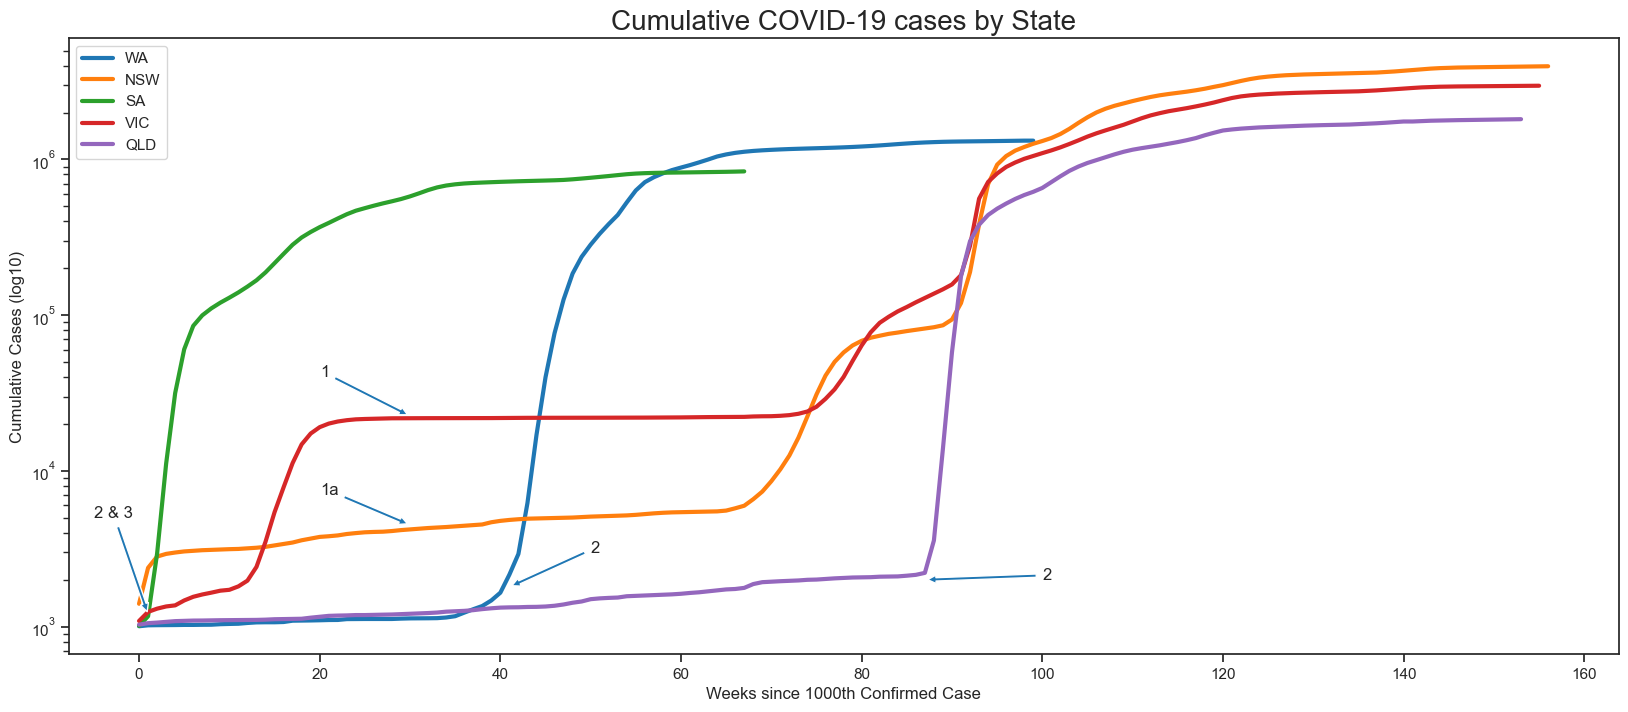

In [51]:
plt.figure(figsize=(20,8))
ax = plt.axes() #creates an object of the axes of the graph
sns.lineplot(x='D0 Delta', y='TOTAL', data=cases_wa_1k, label = 'WA', linewidth=3)
sns.lineplot(x='D0 Delta', y='TOTAL', data=cases_nsw_1k, label = 'NSW', linewidth=3)
sns.lineplot(x='D0 Delta', y='TOTAL', data=cases_sa_1k, label = 'SA', linewidth=3)
sns.lineplot(x='D0 Delta', y='TOTAL', data=cases_vic_1k, label = 'VIC', linewidth=3)
sns.lineplot(x='D0 Delta', y='TOTAL', data=cases_qld_1k, label = 'QLD', linewidth=3)
plt.yscale('log')
sns.set_context("notebook")
sns.set_style("ticks")
ax.set_xlabel('Weeks since 1000th Confirmed Case')
ax.set_ylabel('Cumulative Cases (log10)')
ax.annotate('1', xy=(30,22500), xytext =(20,40000), arrowprops=dict(arrowstyle='simple'))
ax.annotate('1a', xy=(30,4500), xytext =(20,7000), arrowprops=dict(arrowstyle='simple'))
ax.annotate('2', xy=(87,2000), xytext =(100,2000), arrowprops=dict(arrowstyle='simple'))
ax.annotate('2', xy=(41,1800), xytext =(50,3000), arrowprops=dict(arrowstyle='simple'))
ax.annotate('2 & 3', xy=(1,1200), xytext =(-5,5000), arrowprops=dict(arrowstyle='simple'))
plt.title ("Cumulative COVID-19 cases by State", fontsize= 20)



From the chart above it is possible to make several inferences about the effect of lockdowns and the eventual loosening of restrictions and opening of borders:
1. VIC's flat curve from week 20-70 highlights the success the state had in eradicating the disease, as evidenced by the long period with no infections
    * This can be contrasted to NSW who took a 'lighter' approach to lockdowns and continued to experience a low but steady rate of infections through the same (relative) period
2. The effect of restrictions loosening and borders opening in SA, QA and QLD is notable, chacterised by a sudden and steep climb in case numbers
3. SA's success in keeping COVID-19 out of the state through measures such as closed borders is demonstrated by the fact that >1000 cases was only observed post-restrictions etc



## 5. COVID-19 Cases Normalised by Population

The States in this analysis have notably different populations, for example, NSW has almost four times the population of SA. Normalising the new cases against the population size allows for a comparison of how the states performed relative to one another

In [21]:
display(table3)

,Total Cases,Total Deaths,Population (x1000),Infection Rate (Cases per 1000)
State,,,,
NSW,3963582,6574,8153.6,486.1
QLD,1812293,2835,5322.1,340.5
SA,837672,1403,1820.5,460.1
VIC,2971748,7424,6613.7,449.3
WA,1319535,992,2785.3,473.7


Text(0.5, 1.0, 'New COVID-19 Cases by State, Relative to Population Size')

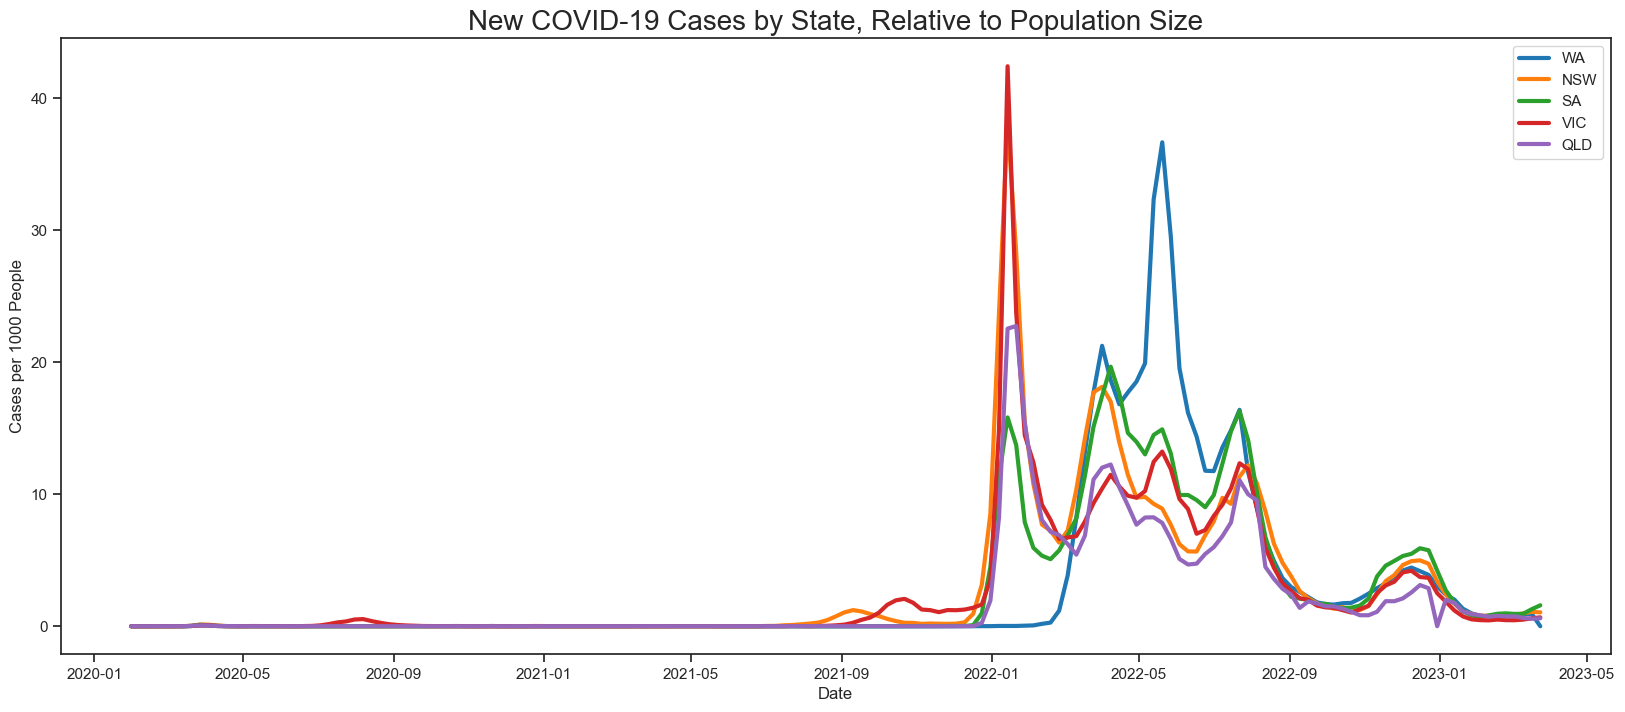

In [48]:
plt.figure(figsize=(20,8))
ax = plt.axes() #creates an object of the axes of the graph
sns.lineplot(x='DATE', y='NEW per 1000', data=cases_wa, label = 'WA', linewidth=3)
sns.lineplot(x='DATE', y='NEW per 1000', data=cases_nsw, label = 'NSW', linewidth=3)
sns.lineplot(x='DATE', y='NEW per 1000', data=cases_sa, label = 'SA', linewidth=3)
sns.lineplot(x='DATE', y='NEW per 1000', data=cases_vic, label = 'VIC', linewidth=3)
sns.lineplot(x='DATE', y='NEW per 1000', data=cases_qld, label = 'QLD', linewidth=3)
sns.set_context("notebook")
sns.set_style("ticks")
ax.set_xlabel('Date')
ax.set_ylabel('Cases per 1000 People')
plt.title ("New COVID-19 Cases by State, Relative to Population Size", fontsize=20)


Discussion:
* Based on the analyis above, NSW, VIC, SA and QLD opened borders and loosened restrictions in early 2022 there was not a proportional infection rate between states
    * As we saw before that NSW and VIC experienced a higher volume of infections than the smaller states, the rate of new cases relative to the population size was also much higher
    * It is worth noting several potential contributing factors:
        * NSW and VIC both experienced more time in lockdown than the smaller states; these populations may have responded differently to those populations who experienced a greater degree of freedom during the early phase of the pandemic
        * Sydney and Melbourne both have large 'hub' airports and are popular tourist destinations, potentially bringing more COVID-19 into these states
* WA, when it opened, initially had a similar rate of infection to the smaller states, but after a short decline the infection rate accelerated notably in winter 2022
* WA aside, the initital differences in infection rate obersved in early 2022 were reduced as 2022 progressed with states experiencing similar numbers of cases relative to population size
* Currently, all states experience a similar number of infections relative to population size
* Overall infection rates (Total number of cases relative to population) were similar across all states, with the exception of QLD which was notably lower

Below is COVID-19 deaths data, normalised by population.

Text(0.5, 1.0, 'New COVID-19 Deaths by State, Relative to Population Size')

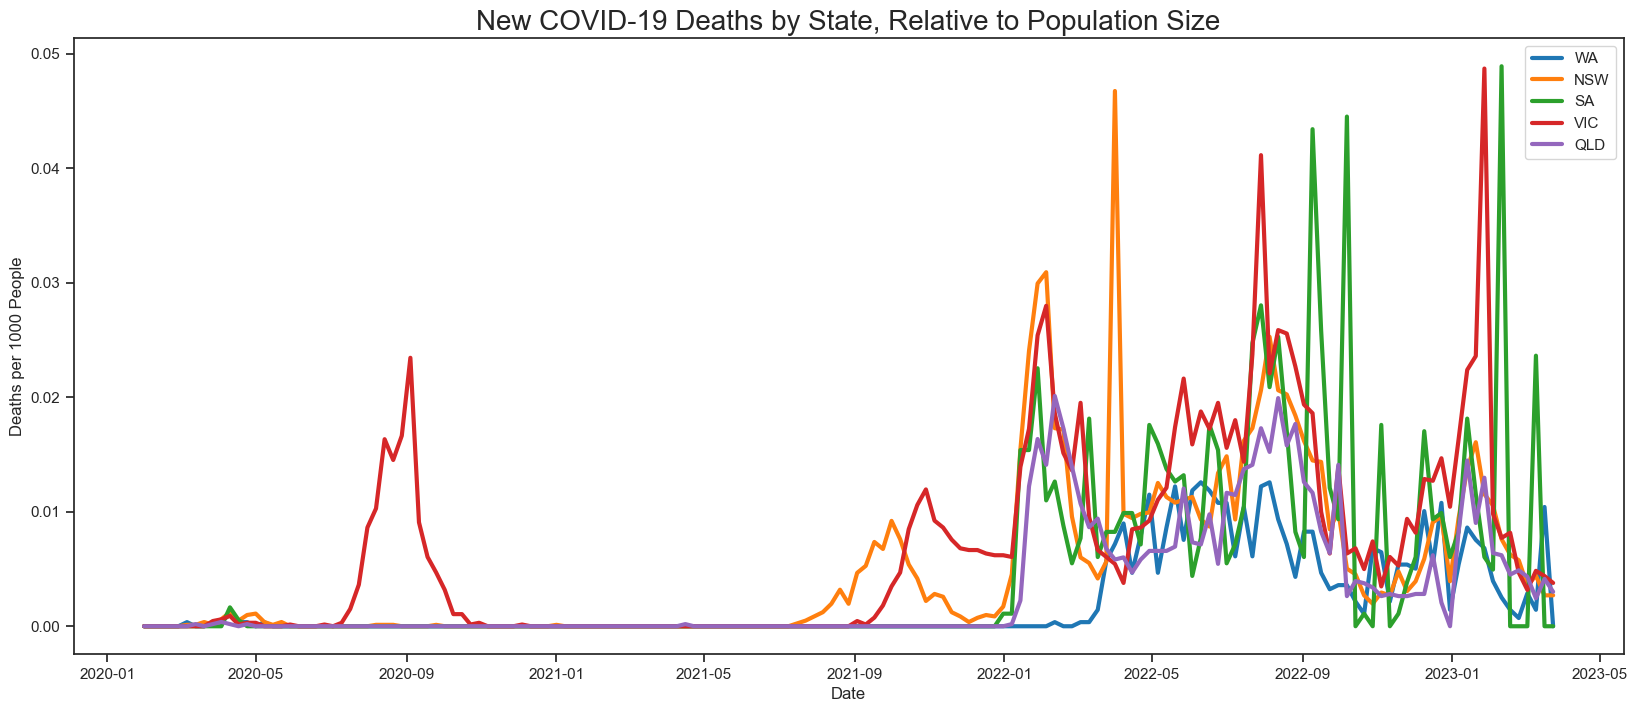

In [52]:
plt.figure(figsize=(20,8))
ax = plt.axes() #creates an object of the axes of the graph
sns.lineplot(x='DATE', y='NET per 1000', data=death_wa, label = 'WA', linewidth=3)
sns.lineplot(x='DATE', y='NET per 1000', data=death_nsw, label = 'NSW', linewidth=3)
sns.lineplot(x='DATE', y='NET per 1000', data=death_sa, label = 'SA', linewidth=3)
sns.lineplot(x='DATE', y='NET per 1000', data=death_vic, label = 'VIC', linewidth=3)
sns.lineplot(x='DATE', y='NET per 1000', data=death_qld, label = 'QLD', linewidth=3)
sns.set_context("notebook")
sns.set_style("ticks")
ax.set_xlabel('Date')
ax.set_ylabel('Deaths per 1000 People')
plt.title ("New COVID-19 Deaths by State, Relative to Population Size", fontsize=20)

Population normalised deaths data is noisy so determining clear trends is difficult, however, there are a few observations to make:
* Even in relative terms, the amount of deaths observed in VIC around Sep 2020, was notably high
* VIC continued to post notable death numbers, relative to population size, in 2022
* SA is notable for posting high deaths relative to population size in 2022
* QLD and WA consistently trended lower than other states for relative deaths
* NSW deaths trended relatively high early on in the pandemic but settled to levels similar to QLD and WA in 2022

## 6. Relationship Between New Cases and Deaths

As seen previously, NSW and VIC were the states with the most cases, and also had the most deaths. Here we will investigate whether the higher number of deaths observed was due to the number/volume of cases

In [24]:
display(table2)

,Total Cases,Total Deaths,Population (x1000),Fatality Rate (Deaths per Case)
State,,,,
NSW,3963582,6574,8153.6,0.0017
QLD,1812293,2835,5322.1,0.0016
SA,837672,1403,1820.5,0.0017
VIC,2971748,7424,6613.7,0.0025
WA,1319535,992,2785.3,0.0008


Assessing the overall fatality rate of a COVID-19 infection, the rate is similar between NSW, QLD and SA but notably different for VIC and WA:
* VIC's fatality rate is notably higher (0.0025 deaths per case vs ~0.0017)
* WAs fatality rate is notably lower (0.0008 deaths per case vs ~0.0017



Text(0, 0.5, 'New Deaths')

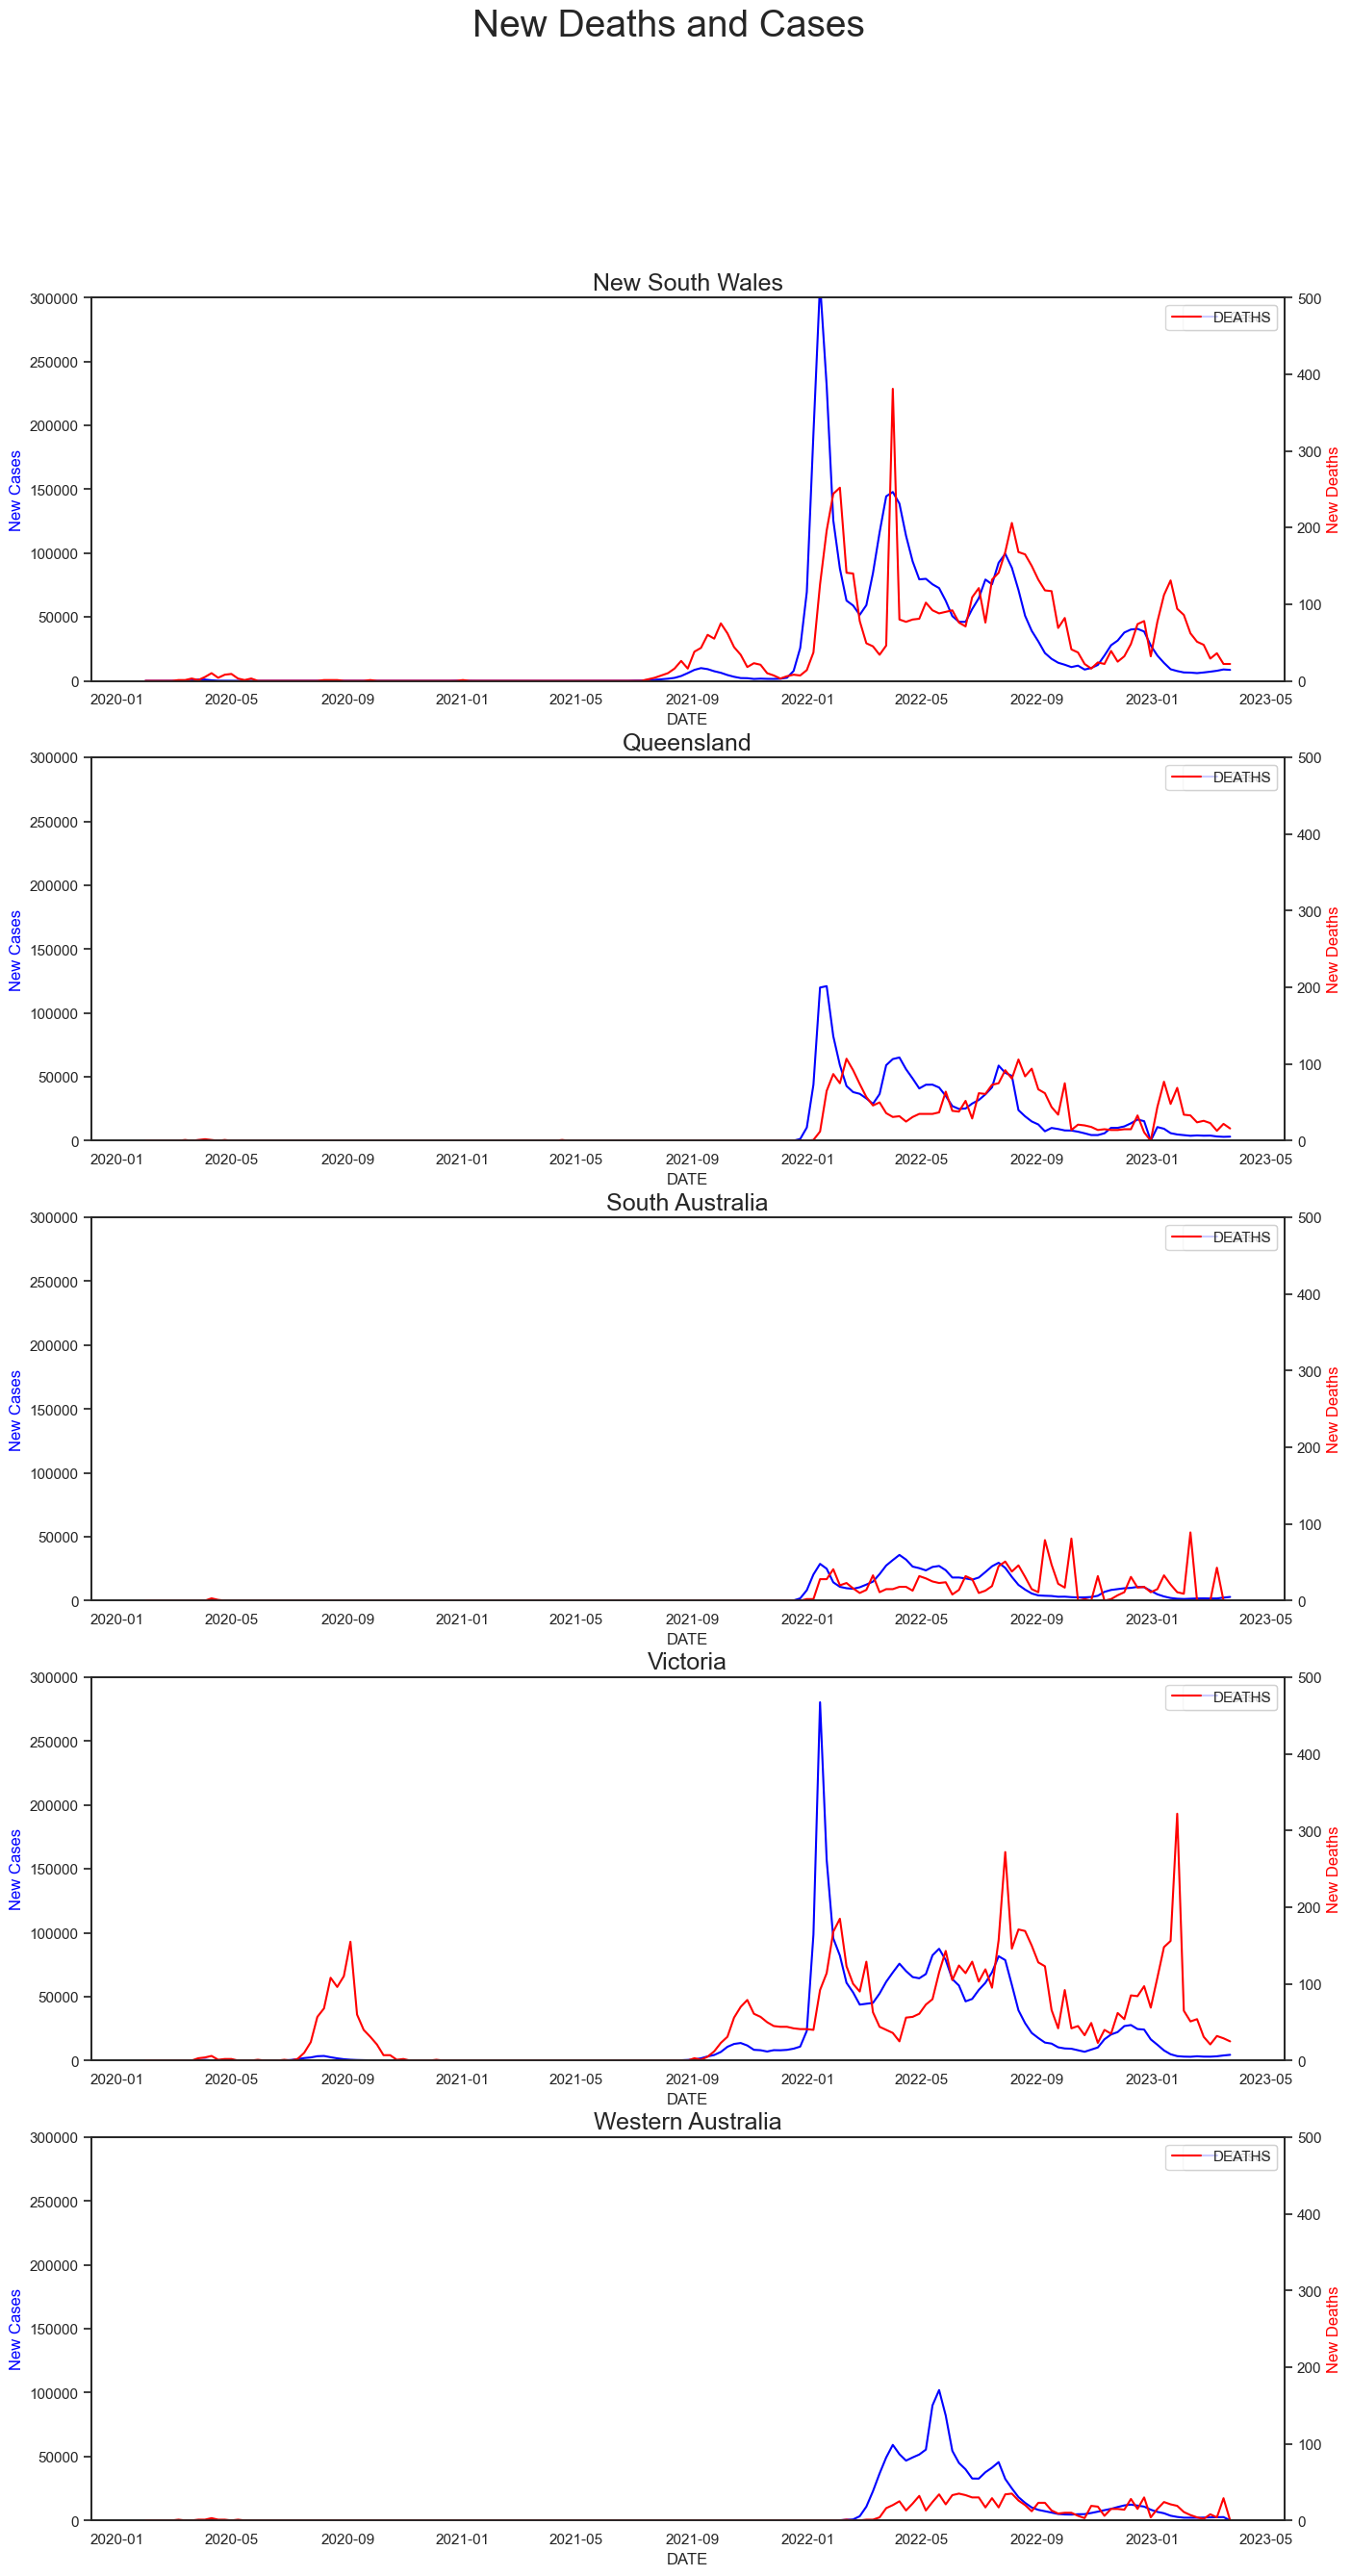

In [25]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(16, 30))
fig.suptitle('New Deaths and Cases', fontsize = 28)
sns.set_context("notebook")
sns.set_style("white")

ax1 = axs[0]
ax1 = sns.lineplot(x='DATE', y='NEW', data=cases_nsw, label = 'Cases', color= 'blue', ax=ax1)
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='DATE', y='NET', data=death_nsw, label = 'DEATHS', color = 'red', ax=ax2)
ax1.set_title("New South Wales", fontsize = 18)
ax1.set_ylim([0, 300000])
ax2.set_ylim([0, 500])
ax1.set_ylabel("New Cases", color = 'blue')
ax2.set_ylabel("New Deaths", color = 'red')

ax1 = axs[1]
ax1 = sns.lineplot(x='DATE', y='NEW', data=cases_qld, label = 'Cases', color= 'blue', ax=ax1)
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='DATE', y='NET', data=death_qld, label = 'DEATHS', color = 'red', ax=ax2)
ax1.set_title("Queensland", fontsize = 18)
ax1.set_ylim([0, 300000])
ax2.set_ylim([0, 500])
ax1.set_ylabel("New Cases", color = 'blue')
ax2.set_ylabel("New Deaths", color = 'red')

ax1 = axs[2]
ax1 = sns.lineplot(x='DATE', y='NEW', data=cases_sa, label = 'Cases', color= 'blue', ax=ax1)
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='DATE', y='NET', data=death_sa, label = 'DEATHS', color = 'red', ax=ax2)
ax1.set_title("South Australia", fontsize = 18)
ax1.set_ylim([0, 300000])
ax2.set_ylim([0, 500])
ax1.set_ylabel("New Cases", color = 'blue')
ax2.set_ylabel("New Deaths", color = 'red')

ax1 = axs[3]
ax1 = sns.lineplot(x='DATE', y='NEW', data=cases_vic, label = 'Cases', color= 'blue', ax=ax1)
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='DATE', y='NET', data=death_vic, label = 'DEATHS', color = 'red', ax=ax2)
ax1.set_title("Victoria", fontsize = 18)
ax1.set_ylim([0, 300000])
ax2.set_ylim([0, 500])
ax1.set_ylabel("New Cases", color = 'blue')
ax2.set_ylabel("New Deaths", color = 'red')

ax1 = axs[4]
ax1 = sns.lineplot(x='DATE', y='NEW', data=cases_wa, label = 'Cases', color= 'blue', ax=ax1)
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='DATE', y='NET', data=death_wa, label = 'DEATHS', color = 'red', ax=ax2)
ax1.set_title("Western Australia", fontsize = 18)
ax1.set_ylim([0, 300000])
ax2.set_ylim([0, 500])
ax1.set_ylabel("New Cases", color = 'blue')
ax2.set_ylabel("New Deaths", color = 'red')


Comparing the number of new cases and new deaths at any given time, there is a trend for more deaths per reported cases earlier in the pandemic, while later in the pandemic, that trend is reversed.

One possible explanation to explain the fatality rate in VIC and WA relate to timing of infections/outbreaks.
* There is a notable spike in deaths in VIC in ~Sep 2021. This spike is notable as it is early on in the pandemic and as a proportion to the reported cases, are quite high
    * Early in the pandemic, population immunity would be assumed non-existent to low due to the lack of infection or vaccination acquired immunity
    * The fatality rate may be higher in VIC as a result of the infections acquired early on in the pandemic
    * The timing of infections however doesn't explain the difference between NSW and VIC, as NSW also experienced a number of infections early in the pandemic, suggesting other contributing factors
* Conversely, WA was one of the last states to open, opening with 'more vaccinated' population

In addition to vaccination rates and population immunity, another relevant factor with respect to the timing of infections/outbreaks is the evolution of the sars-CoV-2 virus. The virus evolved and mutated over time, meaning the virus and its resulting fatality rate, may have changed over time too. 

It is also worth noting:
* There is a trend in all states for 3-4 COVID-19 'waves' starting in early 2022
    * Late 2021 saw states begin to relax restrictions design to reduce COVID-19 transmission
    * February 2022 saw the opening of borders to international visitors
* There is a trend for COVID-19 waves becoming 'smaller' i.e. fewer people infected



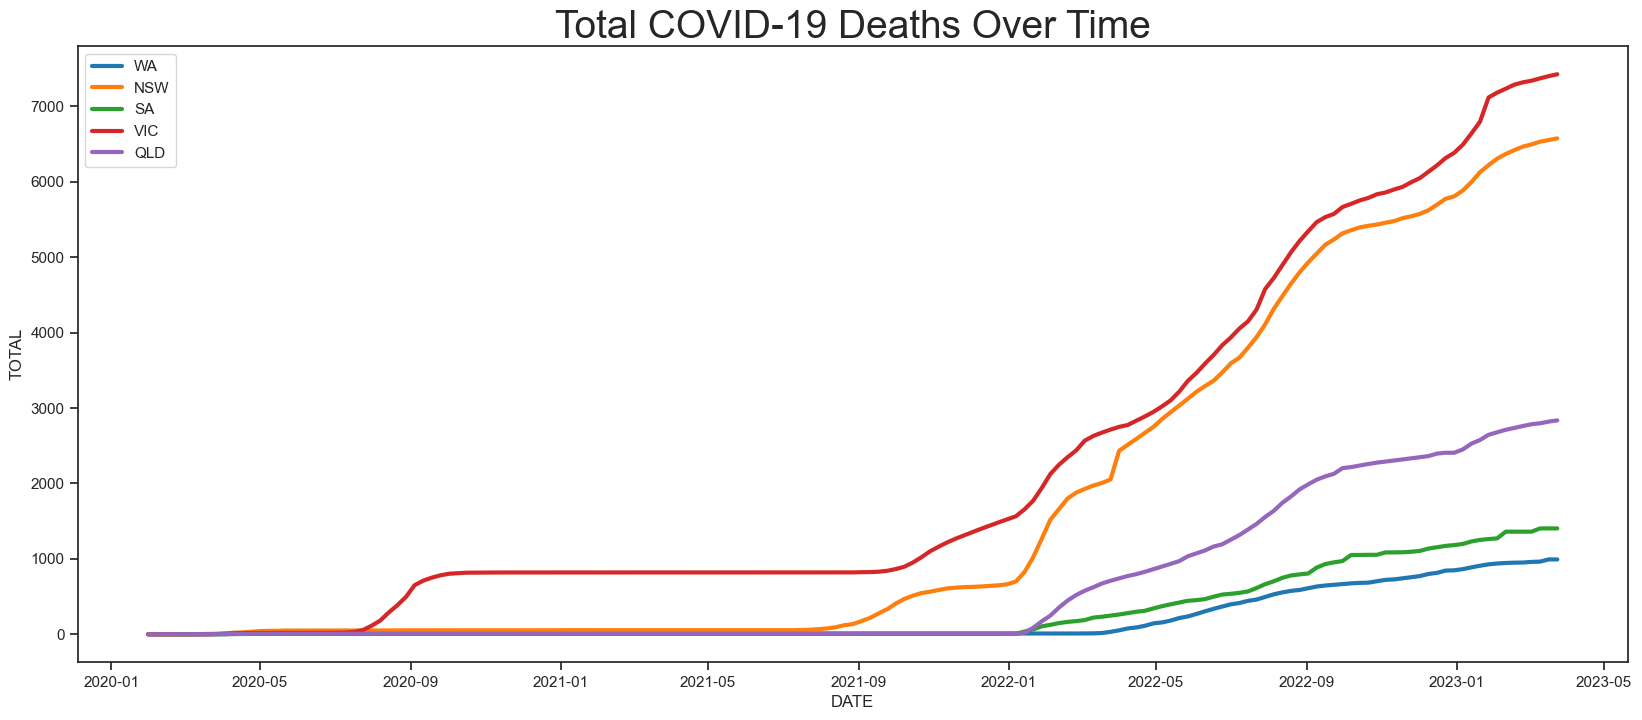

In [53]:
plt.figure(figsize=(20,8))
plt.title("Total COVID-19 Deaths Over Time", fontsize=28)
sns.lineplot(x='DATE', y='TOTAL', data=death_wa, label = 'WA', linewidth=3)
sns.lineplot(x='DATE', y='TOTAL', data=death_nsw, label = 'NSW', linewidth=3)
sns.lineplot(x='DATE', y='TOTAL', data=death_sa, label = 'SA', linewidth=3)
sns.lineplot(x='DATE', y='TOTAL', data=death_vic, label = 'VIC', linewidth=3)
sns.lineplot(x='DATE', y='TOTAL', data=death_qld, label = 'QLD', linewidth=3)
sns.set_context("notebook")
sns.set_style("ticks")


Deaths typically follows a linear trend post 2022; Infection rate doesn't appear to a large or notable impact on fatality rate and only leads to "wobbles" on the curve. This is despite the trend for a spike in deaths following a COVID-19 'wave'.
   * We can infer from this that COVID-19 deaths are happening all the time, even inbetween 'waves' when total infections are lower
   * COVID-19 mortality rate is higher in certain 'at risk' groups such as the elderly or those with underlying medical conditions. 
   * The 'healthy' cohort which makes up the majority of the population, and, potentially, the majority of new infections is considered low risk with respect to COVID-19 mortality and therefore may not contribute to the overall fatality rate accelerating

It is noted that the slope of the trend is consistent with population size and that overall number of deaths correlates with population size.

## 7. Conclusion

This report has analysed data on reported COVID-19 cases and COVID-19 related deaths from the 5 mainland states in Australia.

This report demonstrated that New South Wales and Victoria accounted for the majority of the COVID-19 cases with NSW recording the most cases but VIC recording a higher weekly median average amount of cases. SA recorded the least amount of cases by a notable margin to the second least, WA (838k vs 1320k cases), however WA recorded the least amount of deaths 992 (vs SA's 1403). All states had a trend for very few large outbreaks and deaths with the majority of weekly cases numbers and deaths relatively low.

Assessing the progress of COVID-19 over time in the different states, the effect of lockdowns and travel restrictions on new COVID-19 cases was observed. Lockdowns were shown to be effective and stopping infections, particularly in VIC, and the effect of loosening restrictions and 'opening up' was notable too, particularly in states with limited prior COVID-19.

COVID-19 data from the states was compared normalised by population. Initially there was a difference between states in terms of relative infection when states opened back up in early 2022. However, as 2022 progressed these differences became smaller and states were largely similar by 2023. Normalised death data however continued to be more variable and rates between states continued to show differences into 2023 with SA and VIC have notably high death rates for their population.

Finally, the relationship between new cases and deaths was assessed. It was noted this relationship may have changed over time as it appears to be different between the start and end of the pandemic. This report suggests this may be due immunity within the population (vaccine or infection acquired), a change in the virulence of the virus over time or a combination of factors. It was noted that COVID-19 infection waves do lead to increases in COVID-19 related deaths, however, this effect on the overall death rate does not appear to be dramatic as the COVID-19 death rate remains relatively steady in between waves too.

Looking ahead, COVID-19 looks set to continue to be a public health concern. Infection 'waves' are still presenting however the volume of infected appears to be reducing and vaccination continues. That said, the rate at which COVID-19 continues to kill the vulnerable and at risk in Australian appears not to be reducing. COVID-19 will continue then to have a very real impact to soceity both in terms of the social cost in people losing family and friends and financial cost of the strain placed on public healthcare services.